In [3]:
import os
import json
import re 
import csv 
from pathlib import Path
import time

import easyocr
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
#Dataset League of Legends Scoreboard Rank disponible sur Kaggle: https://www.kaggle.com/datasets/jangenard1/league-ranks
DATA_ROOT = "/kaggle/input/league-ranks"

In [5]:
class ScoreboardDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images_dir = os.path.join(root_dir, "images/train")
        self.labels_dir = os.path.join(root_dir, "labels/train")
        self.transform = transform

        self.image_files = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
    
        label_path = os.path.join(
            self.labels_dir,
            img_name.replace(".jpg", ".json")
        )
    
        image = Image.open(img_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
    
        with open(label_path) as f:
            rank = json.load(f)["rank"].lower()
    
        C, H, W = image.shape
    
        crop = image.permute(1, 2, 0).numpy()

        #crop pour garder uniquement la zone des scores
        crop = crop[:32, W - 400:]

        crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    
        crop = (crop * 255).astype(np.uint8)

        
        crop = cv2.resize(
            crop,
            (500, 50),
            interpolation=cv2.INTER_CUBIC
        )
    
        H, W = crop.shape
    
        teams_score = crop[:, int(0.05 * W):int(0.30 * W)]
        kda = crop[:, int(0.36 * W):int(0.52 * W)]
        cs = crop[:, int(0.64 * W):int(0.78 * W)]
        time = crop[:, int(0.84 * W):]
    
        return { 
            "crop_score": torch.from_numpy(teams_score).unsqueeze(0).float(),
            "crop_kda": torch.from_numpy(kda).unsqueeze(0).float(),
            "crop_cs": torch.from_numpy(cs).unsqueeze(0).float(),
            "crop_time": torch.from_numpy(time).unsqueeze(0).float(),
            "rank": rank,
            "filename": img_name
        }


In [6]:
transform = transforms.ToTensor()
dataset = ScoreboardDataset(DATA_ROOT, transform=transform)

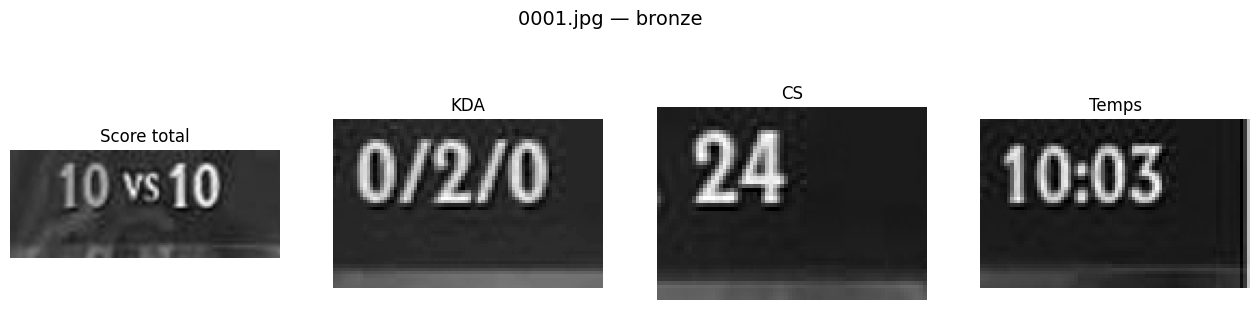

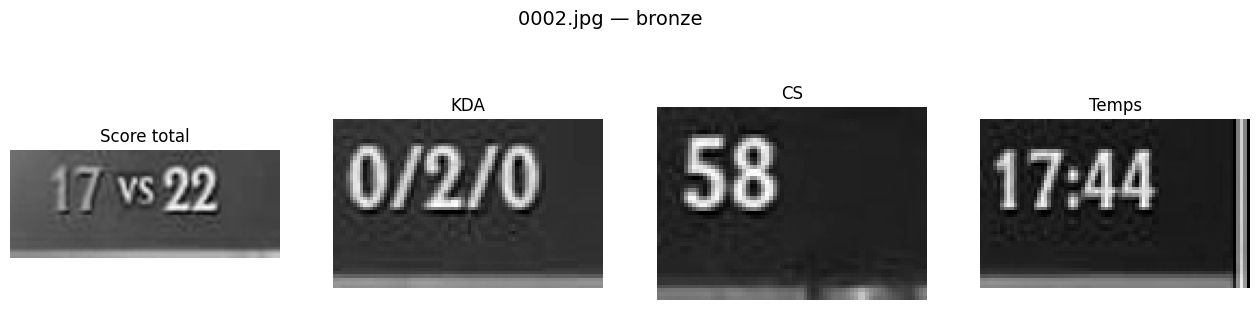

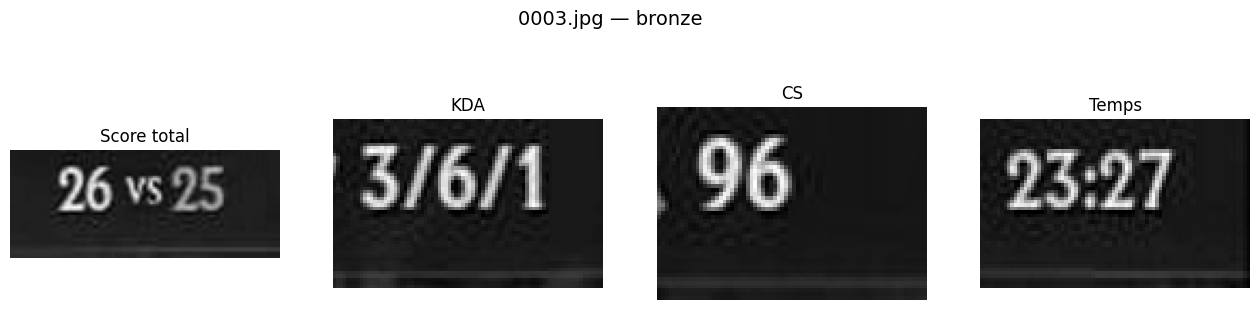

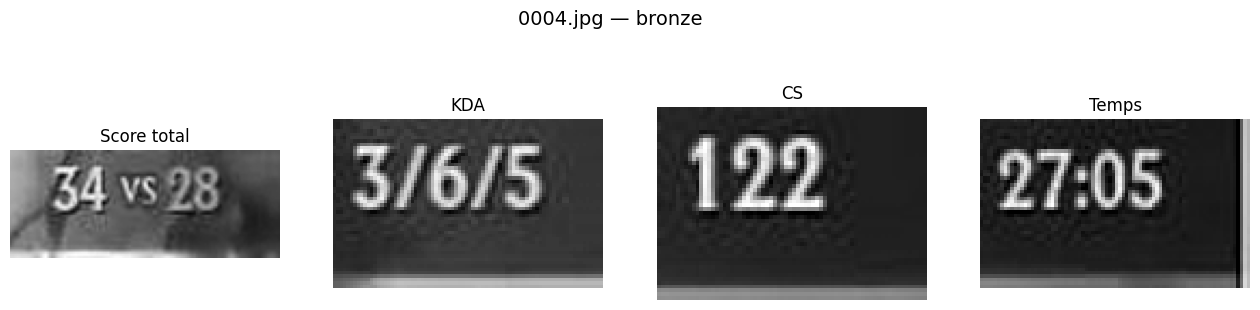

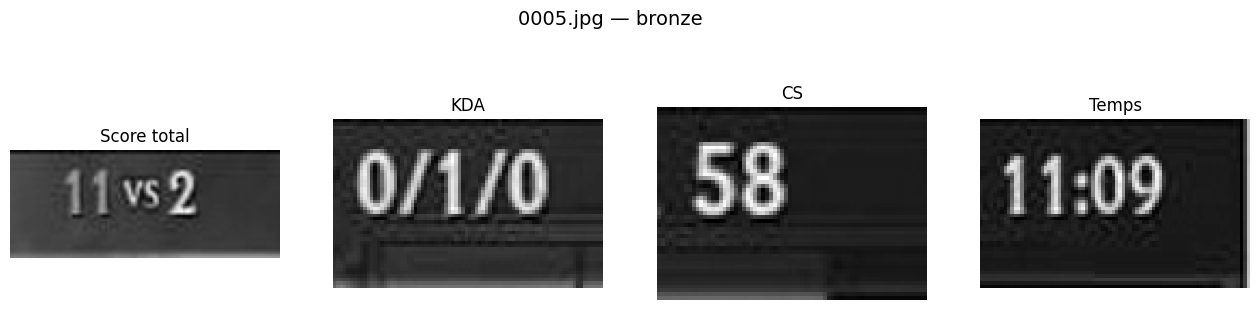

In [7]:
for i in range(5):
    sample = dataset[i]

    score_img = sample["crop_score"]
    kda_img = sample["crop_kda"]
    cs_img = sample["crop_cs"]
    time_img = sample["crop_time"]

    filename = sample["filename"]
    rank = sample["rank"]

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f"{filename} — {rank}", fontsize=14)

    axs[0].imshow(score_img.squeeze(0), cmap="gray")
    axs[0].set_title("Score total")

    axs[1].imshow(kda_img.squeeze(0), cmap="gray")
    axs[1].set_title("KDA")

    axs[2].imshow(cs_img.squeeze(0), cmap="gray")
    axs[2].set_title("CS")

    axs[3].imshow(time_img.squeeze(0), cmap="gray")
    axs[3].set_title("Temps")

    for ax in axs:
        ax.axis("off")

    plt.show()

In [8]:
reader = easyocr.Reader(['en'])

def ocr_image(img):
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 255).astype(np.uint8)
    return reader.readtext(img_np, detail=0)

In [9]:
def parse_team_score(texts):
    joined = " ".join(texts)
    nums = list(map(int, re.findall(r"\d+", joined)))

    if len(nums) >= 2:
        return nums[0], nums[1]
    return None, None

def parse_kda(texts):
    joined = " ".join(texts)
    match = re.search(r"(\d+)\s*/\s*(\d+)\s*/\s*(\d+)", joined)

    if match:
        return map(int, match.groups())
    return None, None, None

def parse_cs(texts):
    nums = list(map(int, re.findall(r"\d+", " ".join(texts))))
    return max(nums) if nums else None

def parse_time(texts):
    joined = " ".join(texts)

    match = re.search(r"(\d{1,2})[.:](\d{2})", joined)
    if match:
        minutes = int(match.group(1))
        seconds = int(match.group(2))
        return minutes + seconds / 60

    return None

In [10]:
def tensor_to_uint8(img_tensor):
    img = img_tensor.squeeze(0).cpu().numpy()

    if img.max() <= 1.0:
        img = (img * 255).astype("uint8")
    else:
        img = img.astype("uint8")

    return img


def ocr_region(img_tensor):
    img = tensor_to_uint8(img_tensor)
    return reader.readtext(img, detail=0)

In [11]:
CSV_PATH = "stats.csv"

FIELDNAMES = [
    "image",
    "rank",
    "total_kills_per_min",
    "kills_per_min",
    "deaths_per_min",
    "kda_ratio",
    "kill_participation",
    "cs_per_min",
    "time"
]
def write_row(row):
    file_exists = Path(CSV_PATH).exists()

    with open(CSV_PATH, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=FIELDNAMES)

        if not file_exists:
            writer.writeheader()

        writer.writerow(row)

In [12]:
for sample in dataset:
    score_img = sample["crop_score"]
    kda_img = sample["crop_kda"]
    cs_img = sample["crop_cs"]
    time_img = sample["crop_time"]

    rank = sample["rank"]
    filename = sample["filename"]

    score_text = ocr_region(score_img)
    kda_text = ocr_region(kda_img)
    cs_text = ocr_region(cs_img)
    time_text = ocr_region(time_img)

    team_kills, enemy_kills = parse_team_score(score_text)
    kills, deaths, assists  = parse_kda(kda_text)
    cs = parse_cs(cs_text)
    time = parse_time(time_text)

    if None in [team_kills, enemy_kills, kills, deaths, assists, cs, time]:
        print(f"[SKIP] OCR failed for {filename}")
        continue


    total_kills_per_min = round((team_kills + enemy_kills) / time, 1)
    kda = round((kills + assists) / (deaths + 1), 2)
    kills_per_min = round(kills / time, 1)
    deaths_per_min = round(deaths / time, 1)
    
    if (kills == 0 and assists == 0) or team_kills == 0 :
        kill_participation=0
    else :
        kill_participation = round((kills + assists) / team_kills, 1)
    cs_per_min = round(cs / time, 2)

    row = {
        "image": filename,
        "rank": rank,
        "total_kills_per_min": total_kills_per_min,
        "kills_per_min": kills_per_min,
        "deaths_per_min": deaths_per_min,
        "kda_ratio": kda,
        "kill_participation": kill_participation,
        "cs_per_min": cs_per_min,
        "time": time
    }

    write_row(row)

[SKIP] OCR failed for 0013.jpg
[SKIP] OCR failed for 0021.jpg
[SKIP] OCR failed for 0023.jpg
[SKIP] OCR failed for 0024.jpg
[SKIP] OCR failed for 0036.jpg
[SKIP] OCR failed for 0049.jpg
[SKIP] OCR failed for 0051.jpg
[SKIP] OCR failed for 0053.jpg
[SKIP] OCR failed for 0056.jpg
[SKIP] OCR failed for 0057.jpg
[SKIP] OCR failed for 0063.jpg
[SKIP] OCR failed for 0065.jpg
[SKIP] OCR failed for 0070.jpg
[SKIP] OCR failed for 0076.jpg
[SKIP] OCR failed for 0084.jpg
[SKIP] OCR failed for 0087.jpg
[SKIP] OCR failed for 0100.jpg
[SKIP] OCR failed for 0103.jpg
[SKIP] OCR failed for 0114.jpg
[SKIP] OCR failed for 0115.jpg
[SKIP] OCR failed for 0116.jpg
[SKIP] OCR failed for 0117.jpg
[SKIP] OCR failed for 0118.jpg
[SKIP] OCR failed for 0119.jpg
[SKIP] OCR failed for 0120.jpg
[SKIP] OCR failed for 0121.jpg
[SKIP] OCR failed for 0122.jpg
[SKIP] OCR failed for 0123.jpg
[SKIP] OCR failed for 0124.jpg
[SKIP] OCR failed for 0125.jpg
[SKIP] OCR failed for 0126.jpg


In [13]:
df = pd.read_csv("stats.csv")

FEATURES = [
    "total_kills_per_min",
    "kills_per_min",
    "deaths_per_min",
    "kda_ratio",
    "kill_participation",
    "cs_per_min",
    "time"
]

X = df[FEATURES]
y = df["rank"]

In [14]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [15]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),
    
    "SVM": SVC(
        kernel="linear",
        class_weight="balanced",
        probability=True,
        random_state=42
    ),
    
    
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        random_state=42
    ),
    "XGBoost" : XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        random_state=42
    )
}

In [16]:
def make_pipeline(model):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
    
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro"
}

In [17]:
results = []

for name, model in models.items():
    pipe = make_pipeline(model)
    scores = cross_validate(
        pipe,
        X,
        y_enc,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    results.append({
        "Model": name,
        "Accuracy (mean)": scores["test_accuracy"].mean(),
        "F1 Macro (mean)": scores["test_f1_macro"].mean(),
        "Accuracy (std)": scores["test_accuracy"].std(),
        "F1 Macro (std)": scores["test_f1_macro"].std()
    })

In [18]:
results_df = pd.DataFrame(results).sort_values(
    by="F1 Macro (mean)",
    ascending=False
)

results_df

,Model,Accuracy (mean),F1 Macro (mean),Accuracy (std),F1 Macro (std)
1,SVM,0.587013,0.531278,0.041396,0.051628
2,Random Forest,0.549784,0.481156,0.058482,0.042602
0,Logistic Regression,0.477922,0.427846,0.089280,0.110260
3,XGBoost,0.503463,0.406920,0.085837,0.079347


In [28]:
best_model_name = results_df.iloc[0]["Model"]
best_model = make_pipeline(models[best_model_name])

best_model.fit(X, y_enc)

Logistic Regression


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])

In [29]:
logistic_model = make_pipeline(models["Logistic Regression"])

logistic_model.fit(X, y_enc)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

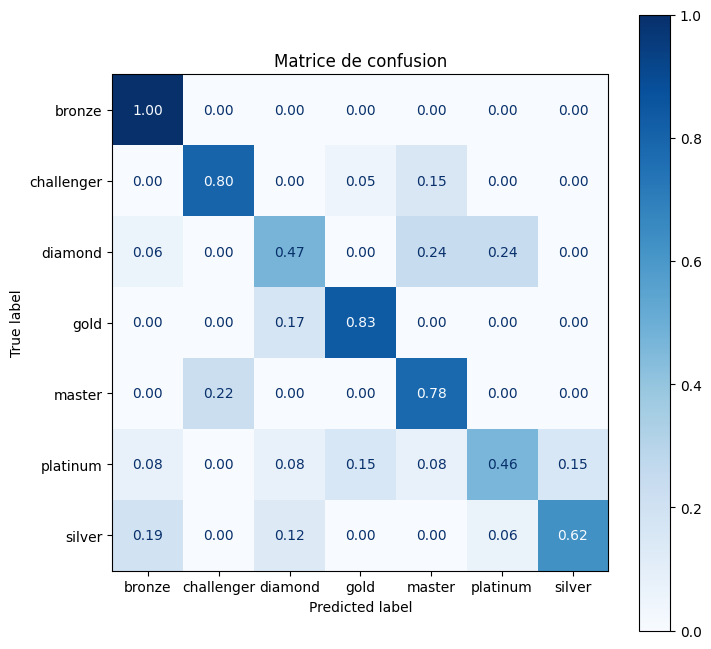

In [30]:
y_pred = best_model.predict(X)

cm = confusion_matrix(y_enc, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Matrice de confusion")
plt.show()

In [21]:
print(
    classification_report(
        y_enc,
        y_pred,
        target_names=le.classes_
    )
)

              precision    recall  f1-score   support

      bronze       0.79      1.00      0.88        19
  challenger       0.80      0.80      0.80        20
     diamond       0.67      0.47      0.55        17
        gold       0.62      0.83      0.71         6
      master       0.64      0.78      0.70        18
    platinum       0.55      0.46      0.50        13
      silver       0.83      0.62      0.71        16

    accuracy                           0.72       109
   macro avg       0.70      0.71      0.69       109
weighted avg       0.72      0.72      0.71       109



In [32]:
clf = logistic_model.named_steps["clf"]
print(best_model)
coef = clf.coef_

coef_df = pd.DataFrame(
    coef,
    columns=X.columns,
    index=le.classes_
)
coef_df

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear', probability=True,
                     random_state=42))])


,total_kills_per_min,kills_per_min,deaths_per_min,kda_ratio,kill_participation,cs_per_min,time
bronze,-0.450001,-0.118416,-0.792544,-0.997732,0.335916,-3.033198,0.444915
challenger,-0.379414,0.348230,0.207982,0.337441,0.516466,3.012665,-0.217323
diamond,0.455001,0.123387,-0.415026,-0.179296,-0.045946,0.188128,-0.238967
gold,-0.282138,0.506439,0.759414,-0.770291,0.447917,-0.145905,0.100517
master,-0.169849,0.174214,0.359339,0.342252,-0.207620,1.962676,-0.136163
platinum,0.595583,-0.642601,0.012242,0.594373,-0.793177,-0.354233,-0.375647
silver,0.230817,-0.391254,-0.131406,0.673253,-0.253555,-1.630133,0.422669


<Figure size 1000x600 with 0 Axes>

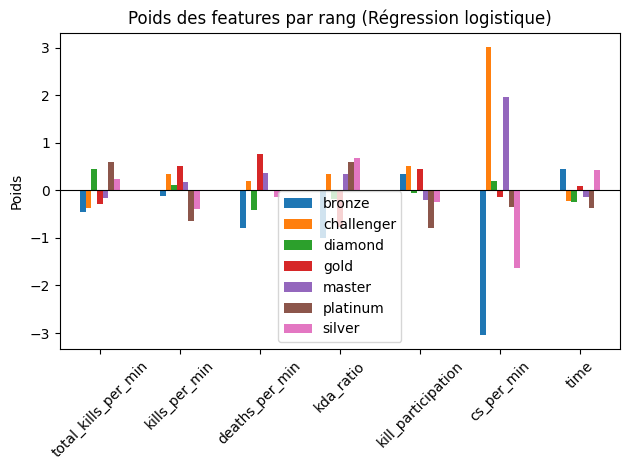

In [33]:
plt.figure(figsize=(10, 6))
coef_df.T.plot(kind="bar")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Poids des features par rang (Régression logistique)")
plt.ylabel("Poids")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X,
    y_enc,
    cv=cv,
    scoring="accuracy",
    train_sizes=np.linspace(0.2, 1.0, 8)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Accuracy d'entraînement")
plt.plot(train_sizes, test_mean, label="Accuracy de validation")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Courbe d'apprentissage")
plt.grid(True)
plt.show()